### **Load Libraries & Datasets**

In [ ]:
# Libraries
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
# Dataset paths and config
# -----------------------------------------------------------------------------
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir  = "/content/drive/MyDrive/chest_xray/test"
BATCH_SIZE = 32
EPOCHS = 30
INPUT_SIZE = 299
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform = val_transform

In [ ]:

# Create full ImageFolder for train_dir and create stratified train/val split
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_targets = np.array([s[1] for s in full_train_dataset.samples])  # labels

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_targets)), train_targets))

train_dataset = Subset(full_train_dataset, train_idx)

# use same underlying ImageFolder but with val_transform
full_train_dataset_val = datasets.ImageFolder(train_dir, transform=val_transform)
val_dataset = Subset(full_train_dataset_val, val_idx)

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


# Dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val':   len(val_dataset),
    'test':  len(test_dataset)
}

class_names = full_train_dataset.classes

In [ ]:
print("Dataset sizes:")
print(f"  Train: {dataset_sizes['train']}")
print(f"  Val:   {dataset_sizes['val']}")
print(f"  Test:  {dataset_sizes['test']}")

Dataset sizes:
  Train: 4708
  Val:   524
  Test:  624


#### **Build Model**

In [ ]:
# Model setup (InceptionV3)
model = models.inception_v3(weights='DEFAULT', aux_logits=True)
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 156MB/s] 


#### **Train model**

In [ ]:
# Training loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Calculate class weights
class_counts = np.bincount([s[1] for s in full_train_dataset.samples])
total_samples = sum(class_counts)
num_classes = len(class_counts)
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

# Update criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    epoch_start = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                # InceptionV3 with aux_logits=True returns a named tuple
                outputs = model(inputs)
                if phase == 'train' and isinstance(outputs, torch.utils.data.dataloader.DataLoader):
                    # Access main output when training
                    outputs = outputs.logits
                elif not isinstance(outputs, torch.Tensor):
                    # Access main output for evaluation if not a tensor
                     outputs = outputs.logits


                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f" {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())


        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_path = os.path.join(os.path.dirname(train_dir), "InceptionV3_best_model_nh.pth")
            torch.save({'model_state_dict': best_model_wts,
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'train_accs': train_accs,
                        'val_accs': val_accs},
                       best_model_path)


    scheduler.step()
    epoch_time = (time.time() - epoch_start) / 60.0
    print(f" Epoch time: {epoch_time:.2f} minutes\n")

print(f"Best val Acc: {best_acc:.4f}")

# save history
history_path = os.path.join(os.path.dirname(train_dir), "history_nh.pth")
torch.save({'train_losses': train_losses, 'val_losses': val_losses,
            'train_accs': train_accs, 'val_accs': val_accs}, history_path)


# load best weights
model.load_state_dict(best_model_wts)

Epoch 1/30
 train Loss: 0.3730 Acc: 0.8709
 val Loss: 0.3048 Acc: 0.9160
 Epoch time: 3.88 minutes

Epoch 2/30
 train Loss: 0.3033 Acc: 0.8781
 val Loss: 0.2443 Acc: 0.9122
 Epoch time: 2.28 minutes

Epoch 3/30
 train Loss: 0.2742 Acc: 0.8912
 val Loss: 0.2170 Acc: 0.9179
 Epoch time: 2.25 minutes

Epoch 4/30
 train Loss: 0.2588 Acc: 0.8972
 val Loss: 0.2109 Acc: 0.9332
 Epoch time: 2.28 minutes

Epoch 5/30
 train Loss: 0.2521 Acc: 0.8978
 val Loss: 0.2135 Acc: 0.9065
 Epoch time: 2.27 minutes

Epoch 6/30
 train Loss: 0.2443 Acc: 0.8991
 val Loss: 0.2018 Acc: 0.9218
 Epoch time: 2.25 minutes

Epoch 7/30
 train Loss: 0.2364 Acc: 0.9087
 val Loss: 0.1931 Acc: 0.9179
 Epoch time: 2.26 minutes

Epoch 8/30
 train Loss: 0.2359 Acc: 0.9038
 val Loss: 0.1994 Acc: 0.9256
 Epoch time: 2.23 minutes

Epoch 9/30
 train Loss: 0.2252 Acc: 0.9133
 val Loss: 0.1975 Acc: 0.9256
 Epoch time: 2.26 minutes

Epoch 10/30
 train Loss: 0.2186 Acc: 0.9114
 val Loss: 0.1800 Acc: 0.9237
 Epoch time: 2.23 minutes


<All keys matched successfully>

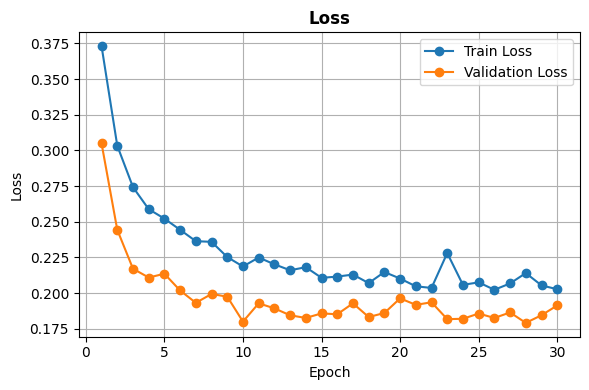

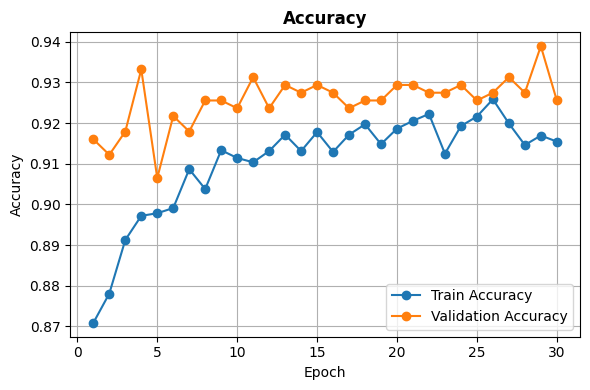

In [ ]:
# Plotting Training History

# Load history from the saved file in case the kernel reset
try:
    history = torch.load(history_path)
    train_losses = history['train_losses']
    val_losses = history['val_losses']
    train_accs = history['train_accs']
    val_accs = history['val_accs']
except FileNotFoundError:
    print(f"History file not found at {history_path}. Using history from memory.")
    # If file not found, use the lists that are still in memory from the training loop

epochs_range = range(1, EPOCHS + 1)

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs_range, val_accs, marker='o', label='Validation Accuracy')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Evaluation**

Total Correct: 546
Total Test Images: 624
Test Accuracy: 0.8750
Test Loss: 0.3202

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9239    0.7265    0.8134       234
   PNEUMONIA     0.8545    0.9641    0.9060       390

    accuracy                         0.8750       624
   macro avg     0.8892    0.8453    0.8597       624
weighted avg     0.8806    0.8750    0.8713       624



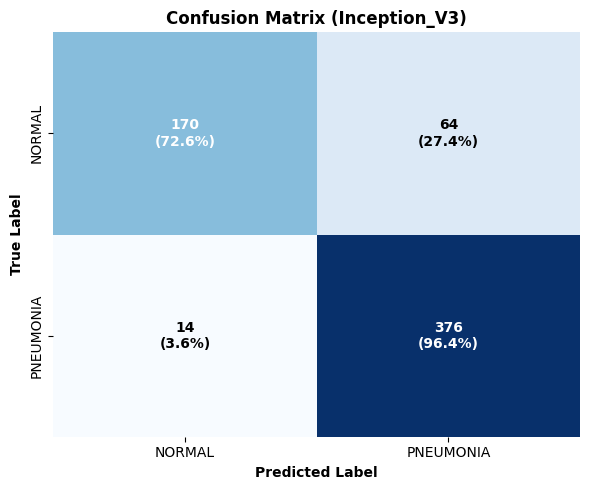


AUROC: 0.9507


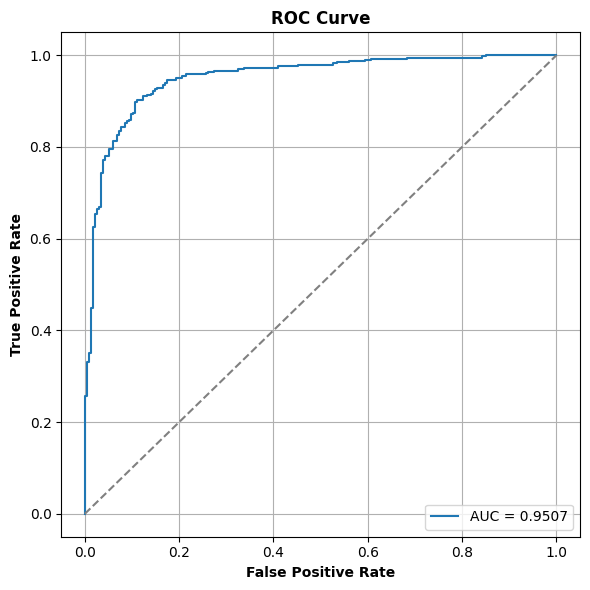

In [ ]:
# Test / Evaluation: compute test loss, accuracy, classification report, AUROC, confusion matrix
model.eval()
all_labels = []
all_probs = []
all_preds = []
test_running_loss = 0.0
test_running_corrects = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        batch_size = inputs.size(0)
        test_running_loss += loss.item() * batch_size
        test_running_corrects += torch.sum(preds == labels.data).item()
        test_total += batch_size

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = test_running_loss / test_total
test_acc = test_running_corrects / test_total

print(f"Total Correct: {int(test_running_corrects)}")
print(f"Total Test Images: {test_total}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}")

# classification report (4 significant figures)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# confusion matrix (counts + row-wise %), bold diagonal
cm = confusion_matrix(all_labels, all_preds)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='white' if i == j else 'black',
                fontweight='bold' )
plt.title("Confusion Matrix (Inception_V3)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# AUROC and ROC curve (4 significant figures)
auc_score = roc_auc_score(all_labels, all_probs)
print(f"\nAUROC: {auc_score:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Total Correct: 546
Total Test Images: 624
Test Accuracy : 0.8750
Test Loss: 0.3202

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9239    0.7265    0.8134       234
   PNEUMONIA     0.8545    0.9641    0.9060       390

    accuracy                         0.8750       624
   macro avg     0.8892    0.8453    0.8597       624
weighted avg     0.8806    0.8750    0.8713       624



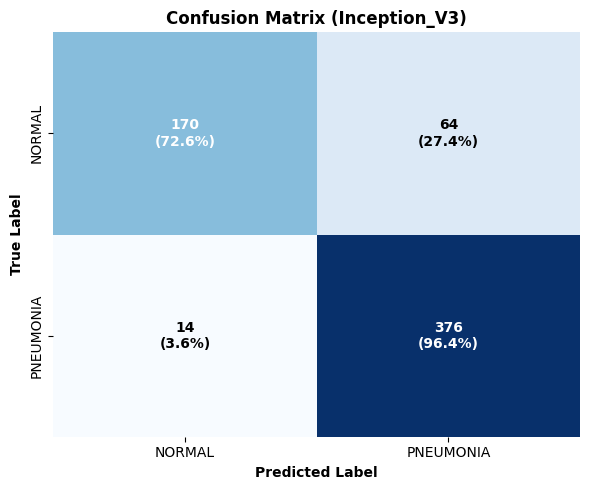


AUROC: 0.9507


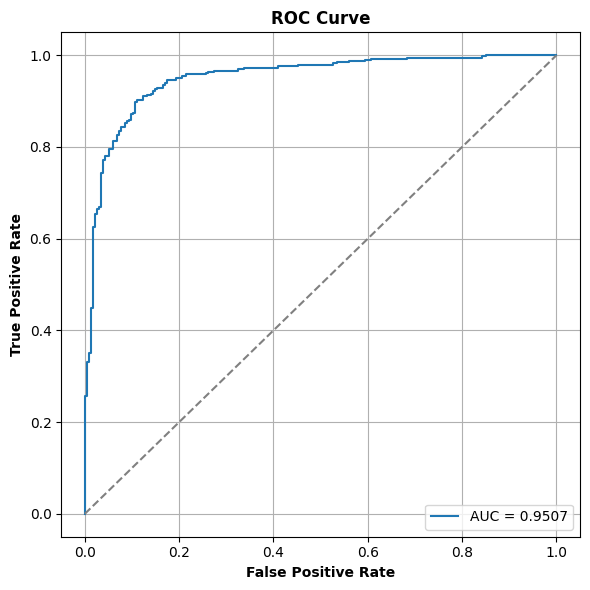

In [ ]:
# -----------------------------------------------------------------------------
# Load best model and perform evaluation with explicit threshold
# -----------------------------------------------------------------------------

# Define the path to the saved best model
best_model_path = os.path.join(os.path.dirname(train_dir), "InceptionV3_best_model_nh.pth")

# Load the saved model state dictionary
# Ensure the model architecture is defined before loading the state dict
model = models.inception_v3(weights='DEFAULT', aux_logits=True)
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)


checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_labels = []
all_probs = []
all_preds_threshold = []  # Predictions based on threshold
test_running_loss = 0.0
test_running_corrects = 0
test_total = 0

# Define the threshold for classification
classification_threshold = 0.5

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        _, preds_max = torch.max(outputs, 1) # Keep this to compare if needed, but not used for metrics

        loss = criterion(outputs, labels)
        batch_size = inputs.size(0)
        test_running_loss += loss.item() * batch_size
        test_total += batch_size

        # Classify based on the defined threshold
        preds_threshold = (probs > classification_threshold).astype(int)
        test_running_corrects += np.sum(preds_threshold == labels.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds_threshold.extend(preds_threshold) # Use threshold predictions for metrics

avg_test_loss = test_running_loss / test_total
test_acc = test_running_corrects / test_total

print(f"Total Correct: {int(test_running_corrects)}")
print(f"Total Test Images: {test_total}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}")

# classification report (4 significant figures)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds_threshold, target_names=class_names, digits=4))

# confusion matrix (counts + row-wise %), bold diagonal
cm = confusion_matrix(all_labels, all_preds_threshold)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='white' if i == j else 'black',
                fontweight='bold')
plt.title("Confusion Matrix (Inception_V3)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# AUROC and ROC curve (4 significant figures)
auc_score = roc_auc_score(all_labels, all_probs)
print(f"\nAUROC: {auc_score:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Model Size & Architecure**





In [ ]:
# Calculate the model size in bytes
model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())

# Convert bytes to megabytes
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 96.80 MB


In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, INPUT_SIZE, INPUT_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,